
# Uber Ride Bookings Project

## 1. Stakeholders, Objectives, and Success Criteria

**Stakeholders**
- **City/Marketplace Ops:** rider/driver matching, supply planning.
- **Finance & Strategy:** revenue forecasting, unit economics, promo budgeting.
- **Risk & Policy:** cancellation risk, service reliability, customer trust.
- **Product & Data:** demand shaping, pricing/promo levers, experimentation.

**Business Goals**
1. **Forecast demand & revenue** by day/week to aid staffing and budgeting.
2. **Reduce cancellations** via classification + decision policy (alerts/incentives).
3. **Price & revenue optimization**: predict booking value and understand drivers.

**Deliverables**
- Forecasts (daily bookings & revenue) with confidence intervals.
- Cancellation risk model with threshold & playbook.
- Booking value regression with key drivers & SHAP-style interpretability.
- Executive summary + risk & limitations, and a handoff checklist.
- Versioned artifacts (models, metrics, charts) saved to `artifacts/`.

**Success Metrics**
- Forecast: MAPE/MAE vs. holdout.
- Cancellation: ROC‑AUC, PR‑AUC, F1, and calibration.
- Regression: MAE/MAPE/R².
- **Economic framing:** expected incremental gross profit under a simple policy.

**Scope & Assumptions**
- Historical bookings are representative; no major regime break in holdout.
- Basic citywide model (no per‑zone model yet). Granularity can be extended.
- All personal data is already anonymized. No PII used.

---

## 2. Data Overview (as provided)

Columns (from the CSV):
- `Date`, `Time`, `Booking ID`, `Booking Status`, `Customer ID`, `Vehicle Type`  
- `Pickup Location`, `Drop Location`, `Avg VTAT`, `Avg CTAT`  
- `Cancelled Rides by Customer`, `Reason for cancelling by Customer`  
- `Cancelled Rides by Driver`, `Driver Cancellation Reason`  
- `Incomplete Rides`, `Incomplete Rides Reason`  
- `Booking Value`, `Ride Distance`, `Driver Ratings`, `Customer Rating`, `Payment Method`

We will engineer features from timestamps, geography tokens, and categories, and apply leakage‑safe, time‑aware splits.

---

## 3. Reproducibility & Environment

Run the install cell below **first** (skip if already installed).


In [ ]:

try:
    import sys
    get_ipython().system(f"{sys.executable} -m pip install --quiet --upgrade pip")
    get_ipython().system(f"{sys.executable} -m pip install --quiet pandas numpy scikit-learn matplotlib plotly statsmodels joblib tqdm")
    # Prophet can be tricky to compile; optional but recommended for forecasting
    get_ipython().system(f"{sys.executable} -m pip install --quiet prophet")
except Exception as e:
    print("Package installation step skipped or failed:", e)


In [ ]:
import os
from pathlib import Path
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             roc_auc_score, average_precision_score, f1_score,
                             confusion_matrix, precision_recall_curve, roc_curve)

import joblib

_FBP_AVAILABLE = True
try:
    from prophet import Prophet
except Exception:
    _FBP_AVAILABLE = False
    from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option("display.max_columns", 100)
BASE = Path().resolve()
ARTIFACTS = BASE / "artifacts"
PLOTS = ARTIFACTS / "plots"
MODELS = ARTIFACTS / "models"
OUTPUTS = BASE / "outputs"
for p in [ARTIFACTS, PLOTS, MODELS, OUTPUTS]:
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = Path("/Users/wenshan/Downloads/ncr_ride_bookings.csv") 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
df = pd.read_csv(DATA_PATH)

df.columns = (df.columns
                .str.strip()
                .str.lower()
                .str.replace(" ", "_")
                .str.replace("/", "_")
                .str.replace("-", "_"))

df["pickup_datetime"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce", format="%d-%m-%Y %H:%M:%S").fillna(pd.NaT)
df["date"] = pd.to_datetime(df["date"], errors="coerce", format="%d-%m-%Y")

print("Rows:", len(df), " | Columns:", len(df.columns))
display(df.head(3))
display(df.isna().mean().sort_values(ascending=False).head(10))


Rows: 150000  | Columns: 22


,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,pickup_datetime
0,NaT,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,NaT,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,NaT
2,NaT,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,NaT


date                                 1.00
pickup_datetime                      1.00
incomplete_rides_reason              0.94
incomplete_rides                     0.94
reason_for_cancelling_by_customer    0.93
cancelled_rides_by_customer          0.93
driver_cancellation_reason           0.82
cancelled_rides_by_driver            0.82
driver_ratings                       0.38
customer_rating                      0.38
dtype: float64


## 4. Exploratory Data Analysis (EDA) Plan

1. Verify distributions and missingness.
2. Plot booking volumes over time; inspect seasonality and trend.
3. Examine cancellation vs. time, vehicle type, and locations.
4. Inspect `booking_value` and `ride_distance` distributions.
5. Quick pivot tables for `payment_method`, `vehicle_type`, and `booking_status`.


In [ ]:
numeric_cols = ["booking_value", "ride_distance", "avg_vtat", "avg_ctat", "driver_ratings", "customer_rating"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

cat_cols = ["booking_status", "vehicle_type", "pickup_location", "drop_location", "payment_method"]
cat_cols = [c for c in cat_cols if c in df.columns]

df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
df["hour"] = df["pickup_datetime"].dt.hour

print("Numeric columns present:", numeric_cols)
print("Categorical columns present:", cat_cols)

display(df[numeric_cols].describe().T if numeric_cols else "No numeric cols found.")

for c in ["booking_status", "vehicle_type", "payment_method"]:
    if c in df.columns:
        print(f"\nValue counts for {c}:")
        print(df[c].value_counts(dropna=False).head(10))

daily = (df.dropna(subset=["date"])
           .groupby("date")
           .agg(bookings=("booking_id", "count"),
                revenue=("booking_value", "sum"))).reset_index()

plt.figure()
plt.plot(daily["date"], daily["bookings"])
plt.title("Daily Bookings")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.tight_layout()
plt.savefig(PLOTS / "daily_bookings.png")
plt.close()

if "booking_value" in df.columns:
    plt.figure()
    df["booking_value"].dropna().plot(kind="hist", bins=50)
    plt.title("Booking Value Distribution")
    plt.xlabel("Booking Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(PLOTS / "booking_value_hist.png")
    plt.close()

print("Saved plots to:", PLOTS)


Numeric columns present: ['booking_value', 'ride_distance', 'avg_vtat', 'avg_ctat', 'driver_ratings', 'customer_rating']
Categorical columns present: ['booking_status', 'vehicle_type', 'pickup_location', 'drop_location', 'payment_method']


,count,mean,std,min,25%,50%,75%,max
booking_value,102000.0,508.295912,395.805774,50.0,234.00,414.00,689.00,4277.0
ride_distance,102000.0,24.637012,14.002138,1.0,12.46,23.72,36.82,50.0
avg_vtat,139500.0,8.456352,3.773564,2.0,5.30,8.30,11.30,20.0
avg_ctat,102000.0,29.149636,8.902577,10.0,21.60,28.80,36.80,45.0
driver_ratings,93000.0,4.230992,0.436871,3.0,4.10,4.30,4.60,5.0
customer_rating,93000.0,4.404584,0.437819,3.0,4.20,4.50,4.80,5.0



Value counts for booking_status:
booking_status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64

Value counts for vehicle_type:
vehicle_type
Auto             37419
Go Mini          29806
Go Sedan         27141
Bike             22517
Premier Sedan    18111
eBike            10557
Uber XL           4449
Name: count, dtype: int64

Value counts for payment_method:
payment_method
NaN            48000
UPI            45909
Cash           25367
Uber Wallet    12276
Credit Card    10209
Debit Card      8239
Name: count, dtype: int64
Saved plots to: /Users/wenshan/Downloads/artifacts/plots



## 5. Feature Engineering

- **Time**: `year, month, dayofweek, hour`  
- **Distance/effort**: `ride_distance`, `avg_vtat`, `avg_ctat`  
- **Service quality**: `driver_ratings`, `customer_rating`  
- **Category dummies**: `vehicle_type`, `payment_method`, locations (tokenized)  
- **Targets**:  
  - Regression: `booking_value` (filter to completed rides to avoid leakage)  
  - Classification: `is_cancelled` (1 if status contains cancellation or incomplete)  
  - Time series: daily `bookings` and `revenue`


In [ ]:
def _to_cancel_flag(s):
    if pd.isna(s):
        return 0
    s = str(s).lower()
    if "cancel" in s or "incomplete" in s:
        return 1
    return 0

df["is_cancelled"] = df["booking_status"].apply(_to_cancel_flag) if "booking_status" in df.columns else 0

completed_mask = (df["is_cancelled"] == 0) & (~df["booking_value"].isna())
df_reg = df.loc[completed_mask].copy()

base_num = [c for c in ["ride_distance", "avg_vtat", "avg_ctat", "driver_ratings", "customer_rating", "hour", "dayofweek"] if c in df.columns]
base_cat = [c for c in ["vehicle_type", "payment_method"] if c in df.columns]

print("Regression rows:", len(df_reg), "| Classifier rows:", len(df))
print("Numeric features:", base_num)
print("Categorical features:", base_cat)


Regression rows: 93000 | Classifier rows: 150000
Numeric features: ['ride_distance', 'avg_vtat', 'avg_ctat', 'driver_ratings', 'customer_rating', 'hour', 'dayofweek']
Categorical features: ['vehicle_type', 'payment_method']



## 6. Train/Test Splits (Time‑Aware)

- **Regression & Classification:** chronological split to avoid leakage.  
- **Time Series:** last `N` days as holdout.


In [9]:
cutoff = df["date"].max() - pd.Timedelta(days=30)
print("Cutoff date:", cutoff.date())

reg_train = df_reg[df_reg["date"] <= cutoff].copy()
reg_test  = df_reg[df_reg["date"] > cutoff].copy()

clf_train = df[df["date"] <= cutoff].copy()
clf_test  = df[df["date"] > cutoff].copy()

print("Regression:", reg_train.shape, reg_test.shape)
print("Classification:", clf_train.shape, clf_test.shape)


Cutoff date: NaT
Regression: (0, 28) (0, 28)
Classification: (0, 28) (0, 28)



## 7. Modeling - Figures

/var/folders/t9/6s4_rg6d0gvg0_tbgj50zst00000gn/T/ipykernel_31600/3195048890.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d2 = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
/var/folders/t9/6s4_rg6d0gvg0_tbgj50zst00000gn/T/ipykernel_31600/3195048890.py:17: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  d2 = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
/var/folders/t9/6s4_rg6d0gvg0_tbgj50zst00000gn/T/ipykernel_31600/3195048890.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see h

Rows: 150000 | Numeric columns used: ['booking_value', 'ride_distance', 'avg_vtat', 'avg_ctat', 'driver_ratings', 'customer_rating', 'hour', 'dayofweek']

Top absolute correlations:
booking_value  dayofweek        0.197210
dayofweek      booking_value    0.197210
avg_ctat       ride_distance    0.101503
ride_distance  avg_ctat         0.101503
avg_vtat       ride_distance    0.063005
ride_distance  avg_vtat         0.063005
avg_ctat       avg_vtat         0.062175
avg_vtat       avg_ctat         0.062175
dayofweek      avg_ctat         0.009261
avg_ctat       dayofweek        0.009261
dtype: float64


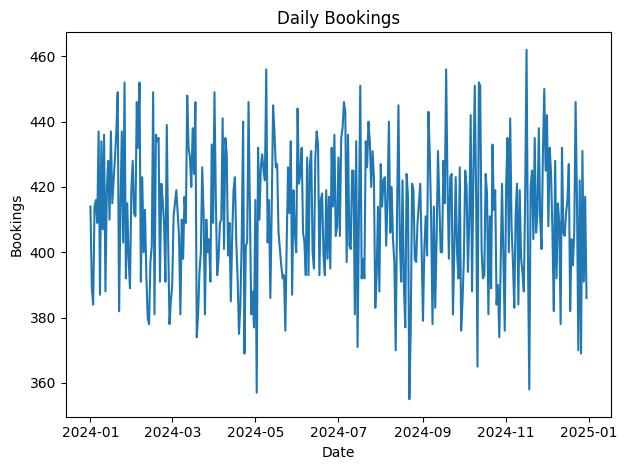

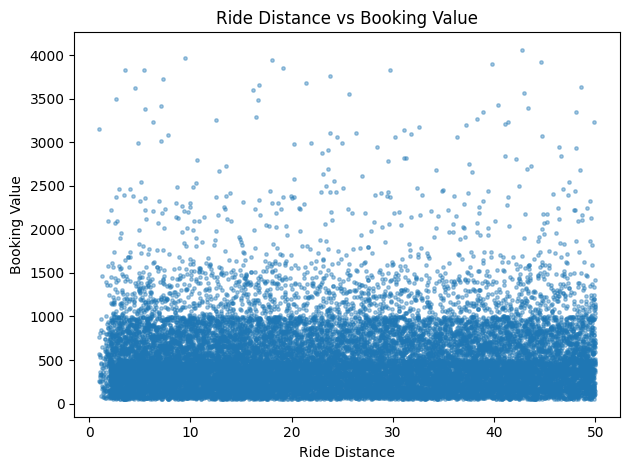

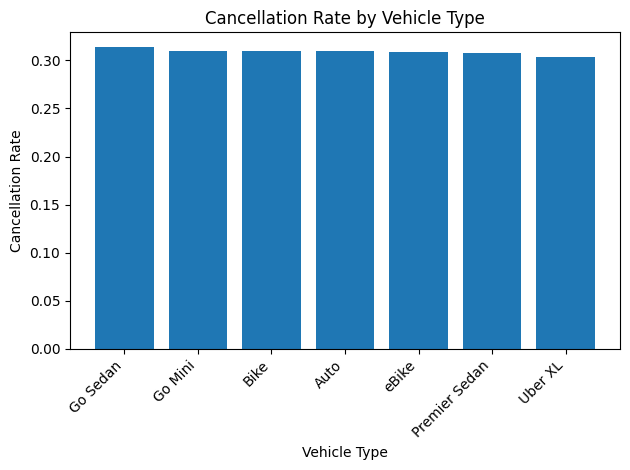

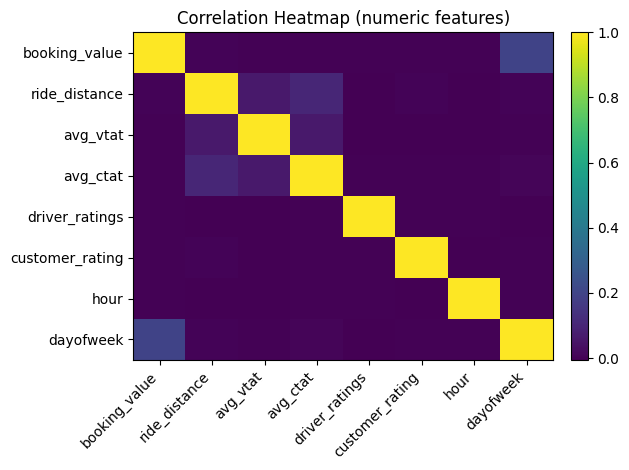


Saved figures to: /Users/wenshan/Downloads/quick_figures


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path("/Users/wenshan/Downloads/ncr_ride_bookings.csv") 
out_dir = Path("./quick_figures"); out_dir.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(" ", "_").str.replace("/", "_").str.replace("-", "_"))

if "date" in df.columns:
    d1 = pd.to_datetime(df["date"], errors="coerce", format="%d-%m-%Y")
    d2 = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
    df["date"] = np.where(d1.notna(), d1, d2)
if "time" in df.columns and "date" in df.columns:
    t1 = pd.to_datetime(df["date"].dt.strftime("%Y-%m-%d") + " " + df["time"].astype(str),
                        errors="coerce", format="%Y-%m-%d %H:%M:%S")
    t2 = pd.to_datetime(df["date"].dt.strftime("%Y-%m-%d") + " " + df["time"].astype(str),
                        errors="coerce", infer_datetime_format=True)
    df["pickup_datetime"] = np.where(t1.notna(), t1, t2)
else:
    df["pickup_datetime"] = pd.NaT

if df["pickup_datetime"].notna().any():
    df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
    df["hour"] = df["pickup_datetime"].dt.hour

def _to_cancel_flag(s):
    s = "" if pd.isna(s) else str(s).lower()
    return 1 if ("cancel" in s or "incomplete" in s) else 0
df["is_cancelled"] = df["booking_status"].apply(_to_cancel_flag) if "booking_status" in df.columns else 0

candidate_numeric = ["booking_value","ride_distance","avg_vtat","avg_ctat","driver_ratings","customer_rating","hour","dayofweek"]
numeric_cols = [c for c in candidate_numeric if c in df.columns]
corr = df[numeric_cols].corr(numeric_only=True) if numeric_cols else pd.DataFrame()

print("Rows:", len(df), "| Numeric columns used:", numeric_cols)
if not corr.empty:
    print("\nTop absolute correlations:")
    corr_long = (corr.abs().where(~np.eye(len(corr),dtype=bool)).stack().sort_values(ascending=False))
    print(corr_long.head(10))

# ---- FIGURE 1: Daily bookings over time ----
if "date" in df.columns and df["date"].notna().any() and "booking_id" in df.columns:
    daily = (df.dropna(subset=["date"]).groupby("date").agg(bookings=("booking_id","count")).reset_index())
    plt.figure()
    plt.plot(daily["date"], daily["bookings"])
    plt.title("Daily Bookings")
    plt.xlabel("Date"); plt.ylabel("Bookings"); plt.tight_layout()
    plt.savefig(out_dir/"fig1_daily_bookings.png"); plt.show()

# ---- FIGURE 2: Scatter — distance vs value ----
if all(c in df.columns for c in ["ride_distance","booking_value"]):
    tmp = df[["ride_distance","booking_value"]].dropna().sample(min(20000, len(df)), random_state=0) if len(df)>20000 else df[["ride_distance","booking_value"]].dropna()
    plt.figure()
    plt.scatter(tmp["ride_distance"], tmp["booking_value"], s=6, alpha=0.4)
    plt.title("Ride Distance vs Booking Value")
    plt.xlabel("Ride Distance"); plt.ylabel("Booking Value"); plt.tight_layout()
    plt.savefig(out_dir/"fig2_distance_vs_value.png"); plt.show()

# ---- FIGURE 3: Cancellation rate by vehicle type ----
if "vehicle_type" in df.columns and "is_cancelled" in df.columns:
    rate = (df.groupby("vehicle_type")["is_cancelled"].mean().sort_values(ascending=False).head(8))
    plt.figure()
    plt.bar(rate.index.astype(str), rate.values)
    plt.title("Cancellation Rate by Vehicle Type")
    plt.xlabel("Vehicle Type"); plt.ylabel("Cancellation Rate")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(out_dir/"fig3_cancel_rate_by_vehicle.png"); plt.show()

# ---- FIGURE 4: Correlation heatmap of numeric cols ----
if not corr.empty:
    plt.figure()
    im = plt.imshow(corr.values, aspect="auto")
    plt.title("Correlation Heatmap (numeric features)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(out_dir/"fig4_corr_heatmap.png"); plt.show()

print("\nSaved figures to:", out_dir.resolve())
